In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Data_v2
import Data_analysis_func
import Model_checks
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
import Outlier_detection_v2
import Genes_self_similarity_v2
from matplotlib_venn import venn2, venn2_circles
import Feature_engineering
import Clusters
from tqdm import tqdm

In [5]:
data = Data_v2.get_format_data_without_na()
data_norm_flagged = Data_v2.get_norm_flagged_data()

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:185: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_copy.at[index, column_name] -= wt_mean_y2[i - 1]
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:193: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_copy.at[index, column_name] -= wt_mean_ynpq[i - 1]


In [6]:
data_norm_features = Feature_engineering.extract_features(data_norm_flagged)

100%|██████████| 53523/53523 [06:46<00:00, 131.62it/s]


AttributeError: module 'Data_v2' has no attribute 'get_smoothed_data'

In [8]:
data_smoothed = Data_v2.get_smooth_data(data_norm_features)

In [93]:
alpha = 0.05
Outlier_detection_v2.detect_diverging_outliers(data_norm_features, alpha=alpha, p=(1/2), w=10)
Outlier_detection_v2.detect_outlier_mean_reduced_v2(data_norm_features, alpha=alpha)
Outlier_detection_v2.detect_outliers_abs_var_y2(data_norm_features, alpha)

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Outlier_detection_v2.py:601: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 

In [19]:
shape_threshold_distances_y2 = pd.read_csv('shape_threshold_distances_y2.csv', index_col=0)

In [21]:
# make it into a dict
shape_threshold_distances_y2_dict = shape_threshold_distances_y2.to_dict('records')[0]

In [24]:
data_smoothed_flagged = Genes_self_similarity_v2.apply_shape_flagging_mutants(data_smoothed, shape_threshold_distances_y2_dict, shape_threshold_distances_y2_dict, p=(2/3))

In [94]:
data_slopes = Feature_engineering.get_slope(data_norm_features)

In [151]:
data_slope_cluster = Outlier_detection_v2.detect_and_cluster_slopes(data_slopes, alpha=0.05)

In [87]:
data_norm_features['outlier_abs_var_y2'].value_counts()

outlier_abs_var_y2
False    41322
True     12201
Name: count, dtype: int64

In [152]:
data_slope_cluster['slope_cluster_y2'].value_counts()

slope_cluster_y2
 0    38841
-1    10164
 1     4518
Name: count, dtype: int64

In [154]:
len(data_slope_cluster[(data_slope_cluster['slope_cluster_y2'] == 0) & (data_slope_cluster['outlier_abs_var_y2'] == True)])

2296

In [163]:
data_slope_cluster[data_slope_cluster['mutant_ID'] == 'WT']['slope_cluster_y2'].value_counts(normalize=True)

slope_cluster_y2
 0    0.951646
-1    0.025342
 1    0.023012
Name: proportion, dtype: float64

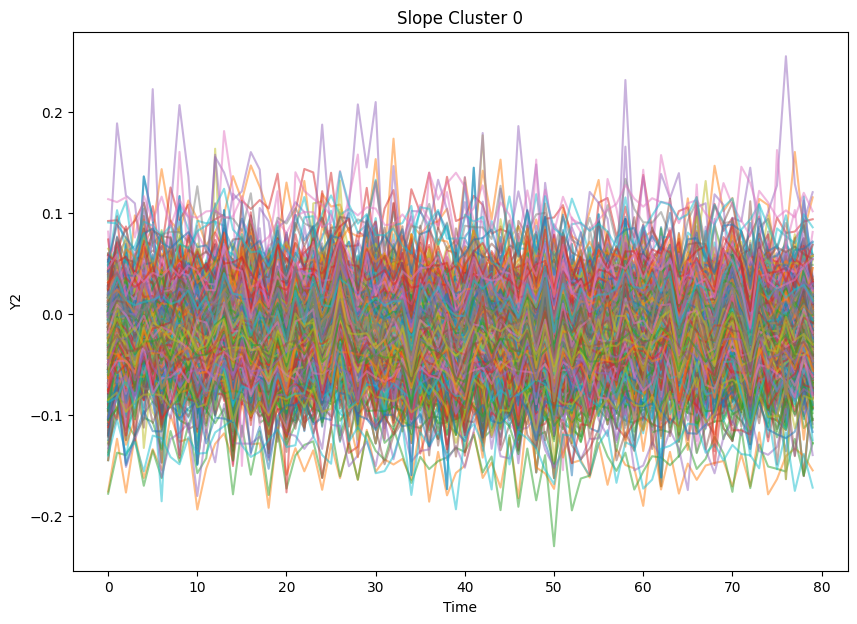

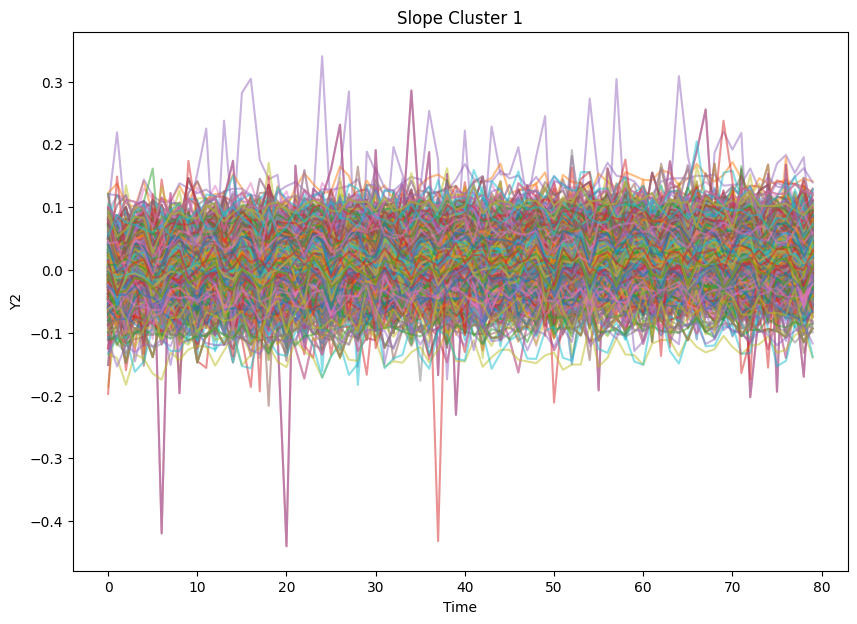

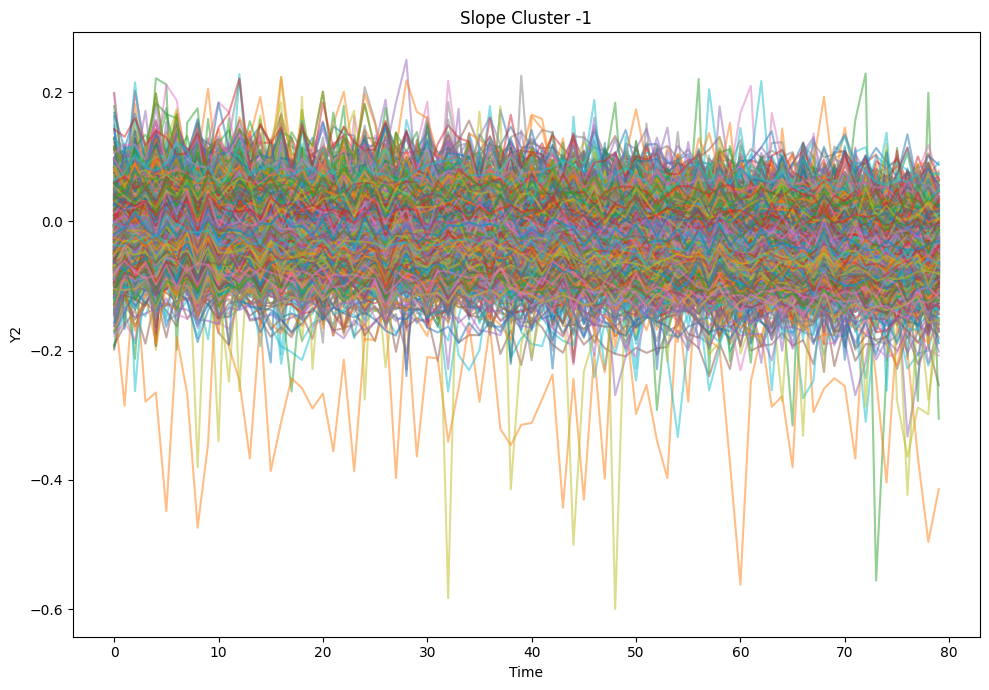

In [155]:
# plot the different clusters
data_cluster = data_slope_cluster.reset_index(drop=True)

for cluster in data_cluster['slope_cluster_y2'].unique():
    data_cluster_slope = data_cluster[(data_cluster['slope_cluster_y2'] == cluster)]
    data_y2 = data_cluster_slope.filter(like='y2_').values
    plt.figure(figsize=(10, 7))
    plt.plot(data_y2[:1000].T, alpha=0.5)
    plt.title(f'Slope Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Y2')

plt.tight_layout()
plt.show()

In [156]:
# Filter genes based on the condition
selected_genes = []

for i, gene in enumerate(data_slope_cluster['mutated_genes'].unique()):
    meets_condition_count = 0
    meets_condition_outlier_count = 0
    total_lights = len(data_slope_cluster['light_regime'].unique())
    for light in data_slope_cluster['light_regime'].unique():
        clusters = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene) & (data_slope_cluster['light_regime'] == light)]['slope_cluster_y2'].value_counts(normalize=True)
        if any(freq >= 0.6 for index, freq in clusters.items() if index != 0):
            meets_condition_outlier_count += 1
        elif any(freq >= 0.6 for freq in clusters.values):
            meets_condition_count += 1

    if meets_condition_count + meets_condition_outlier_count >= total_lights * 0.8 and meets_condition_outlier_count >= 1:
        selected_genes.append(gene)

In [157]:
len(selected_genes)

1235

In [158]:
selected_genes_filtered = [gene for gene in selected_genes if len(data_cluster[data_cluster['mutated_genes'] == gene]['mutant_ID'].unique()) >= 2]

In [159]:
len(selected_genes_filtered)

598

In [160]:
data_slope_cluster[data_slope_cluster['mutated_genes'].isin(selected_genes_filtered)]['mutant_ID'].nunique()

1855

In [137]:
data_slope_cluster[data_slope_cluster['mutated_genes'] == gene_of_interest]

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,mask_area,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,y2_11,y2_12,y2_13,y2_14,y2_15,y2_16,y2_17,y2_18,y2_19,y2_20,y2_21,y2_22,y2_23,y2_24,y2_25,y2_26,y2_27,y2_28,y2_29,y2_30,y2_31,y2_32,y2_33,y2_34,y2_35,y2_36,y2_37,y2_38,y2_39,y2_40,y2_41,y2_42,y2_43,y2_44,y2_45,y2_46,y2_47,y2_48,y2_49,y2_50,y2_51,y2_52,y2_53,y2_54,y2_55,y2_56,y2_57,y2_58,y2_59,y2_60,y2_61,y2_62,y2_63,y2_64,y2_65,y2_66,y2_67,y2_68,y2_69,y2_70,y2_71,y2_72,y2_73,y2_74,y2_75,y2_76,y2_77,y2_78,y2_79,y2_80,ynpq_1,ynpq_2,ynpq_3,ynpq_4,ynpq_5,ynpq_6,ynpq_7,ynpq_8,ynpq_9,ynpq_10,ynpq_11,ynpq_12,ynpq_13,ynpq_14,ynpq_15,ynpq_16,ynpq_17,ynpq_18,ynpq_19,ynpq_20,ynpq_21,ynpq_22,ynpq_23,ynpq_24,ynpq_25,ynpq_26,ynpq_27,ynpq_28,ynpq_29,ynpq_30,ynpq_31,ynpq_32,ynpq_33,ynpq_34,ynpq_35,ynpq_36,ynpq_37,ynpq_38,ynpq_39,ynpq_40,ynpq_41,ynpq_42,ynpq_43,ynpq_44,ynpq_45,ynpq_46,ynpq_47,ynpq_48,ynpq_49,ynpq_50,ynpq_51,ynpq_52,ynpq_53,ynpq_54,ynpq_55,ynpq_56,ynpq_57,ynpq_58,ynpq_59,ynpq_60,ynpq_61,ynpq_62,ynpq_63,ynpq_64,ynpq_65,ynpq_66,ynpq_67,ynpq_68,ynpq_69,ynpq_70,ynpq_71,ynpq_72,ynpq_73,ynpq_74,ynpq_75,ynpq_76,ynpq_77,ynpq_78,ynpq_79,ynpq_80,measurement_time_0,measurement_time_1,measurement_time_2,measurement_time_3,measurement_time_4,measurement_time_5,measurement_time_6,measurement_time_7,measurement_time_8,measurement_time_9,measurement_time_10,measurement_time_11,measurement_time_12,measurement_time_13,measurement_time_14,measurement_time_15,measurement_time_16,measurement_time_17,measurement_time_18,measurement_time_19,measurement_time_20,measurement_time_21,measurement_time_22,measurement_time_23,measurement_time_24,measurement_time_25,measurement_time_26,measurement_time_27,measurement_time_28,measurement_time_29,measurement_time_30,measurement_time_31,measurement_time_32,measurement_time_33,measurement_time_34,measurement_time_35,measurement_time_36,measurement_time_37,measurement_time_38,measurement_time_39,measurement_time_40,measurement_time_41,measurement_time_42,measurement_time_43,measurement_time_44,measurement_time_45,measurement_time_46,measurement_time_47,measurement_time_48,measurement_time_49,measurement_time_50,measurement_time_51,measurement_time_52,measurement_time_53,measurement_time_54,measurement_time_55,measurement_time_56,measurement_time_57,measurement_time_58,measurement_time_59,measurement_time_60,measurement_time_61,measurement_time_62,measurement_time_63,measurement_time_64,measurement_time_65,measurement_time_66,measurement_time_67,measurement_time_68,measurement_time_69,measurement_time_70,measurement_time_71,measurement_time_72,measurement_time_73,measurement_time_74,measurement_time_75,measurement_time_76,measurement_time_77,measurement_time_78,measurement_time_79,measurement_time_80,measurement_time_81,F_0,Fm_0,F_1,Fm_1,F_2,Fm_2,F_3,Fm_3,F_4,Fm_4,F_5,Fm_5,F_6,Fm_6,F_7,Fm_7,F_8,Fm_8,F_9,Fm_9,F_10,Fm_10,F_11,Fm_11,F_12,Fm_12,F_13,Fm_13,F_14,Fm_14,F_15,Fm_15,F_16,Fm_16,F_17,Fm_17,F_18,Fm_18,F_19,Fm_19,F_20,Fm_20,F_21,Fm_21,F_22,Fm_22,F_23,Fm_23,F_24,Fm_24,F_25,Fm_25,F_26,Fm_26,F_27,Fm_27,F_28,Fm_28,F_29,Fm_29,F_30,Fm_30,F_31,Fm_31,F_32,Fm_32,F_33,Fm_33,F_34,Fm_34,F_35,Fm_35,F_36,Fm_36,F_37,Fm_37,F_38,Fm_38,F_39,Fm_39,F_40,Fm_40,F_41,Fm_41,F_42,Fm_42,F_43,Fm_43,F_44,Fm_44,F_45,Fm_45,F_46,Fm_46,F_47,Fm_47,F_48,Fm_48,F_49,Fm_49,F_50,Fm_50,F_51,Fm_51,F_52,Fm_52,F_53,Fm_53,F_54,Fm_54,F_55,Fm_55,F_56,Fm_56,F_57,Fm_57,F_58,Fm_58,F_59,Fm_59,F_60,Fm_60,F_61,Fm_61,F_62,Fm_62,F_63,Fm_63,F_64,Fm_64,F_65,Fm_65,F_66,Fm_66,F_67,Fm_67,F_68,Fm_68,F_69,Fm_69,F_70,Fm_70,F_71,Fm_71,F_72,Fm_72,F_73,Fm_73,F_74,Fm_74,F_75,Fm_75,F_76,Fm_76,F_77,Fm_77,F_78,Fm_78,F_79,Fm_79,F_80,Fm_80,F_81,Fm_81,well_id,mutant_ID,feature,mutated_genes,num_mutations,fv_fm_end,ynpqend,well_id_numeric,mean_y2,mean_ynpq,median,log_likelihood_null,mutated_genes_light_regime_count,fv_fm_WT,fv_fm_end_WT,ynpqend_WT,flag_y2,flag_ynpq,StdDev_y2,Skewness_y2,Kurtosis_y2,Linear_coef_y2,Quadratic_coef_

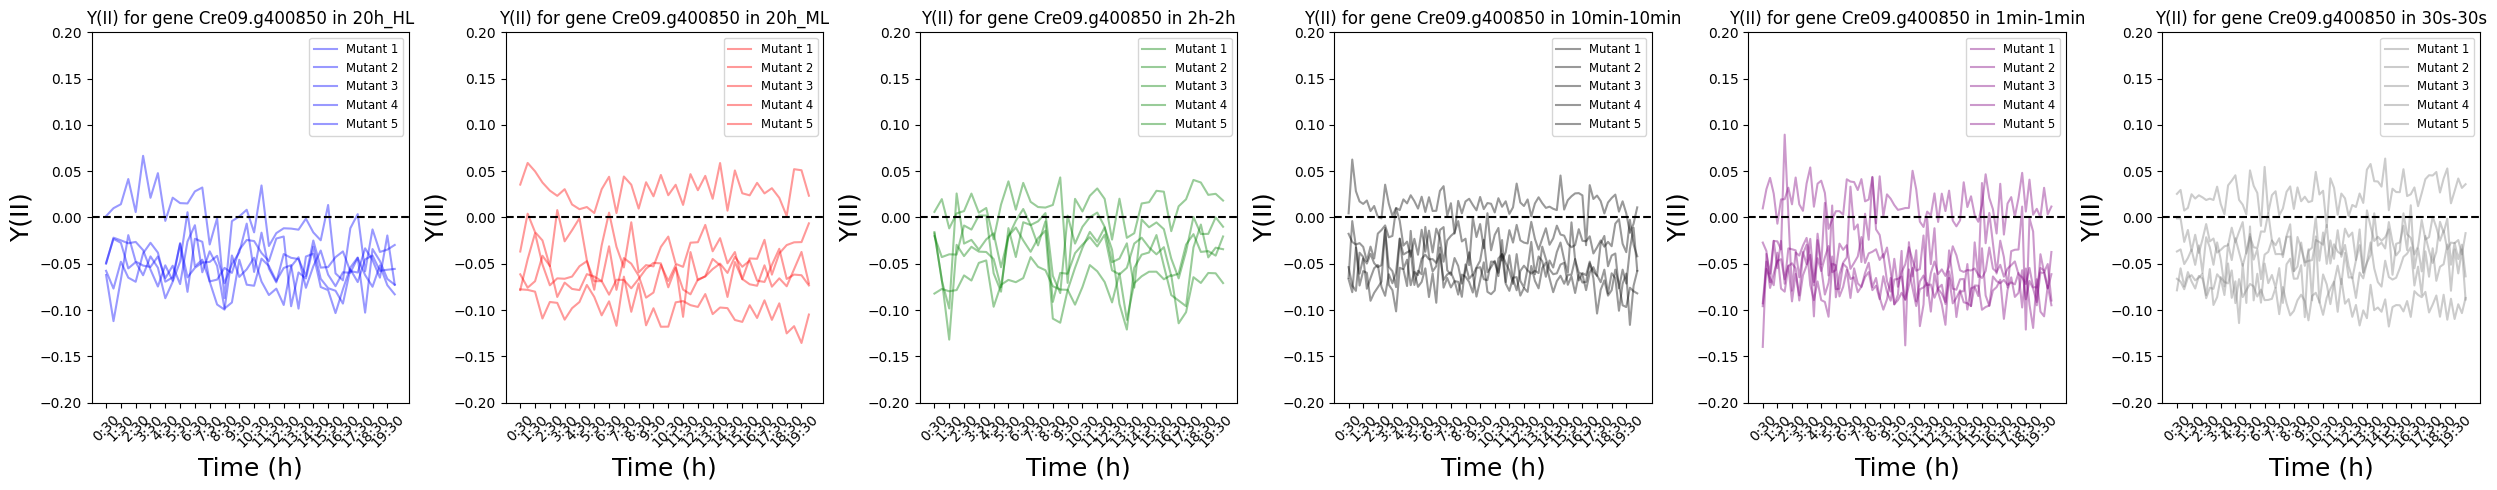

In [169]:
list_genes = [5]

# Define the gene of interest and light regimes
gene_of_interest = selected_genes_filtered[2]
# gene_of_interest = data_cluster[data_cluster['mutated_genes'].isin(selected_genes_filtered)].sort_values(by='slope_y2')['mutated_genes'].unique()[100]
# gene_of_interest = data_cluster['mutated_genes'].unique()[350]
# gene_of_interest = final_mutants['mutated_genes'].unique()[180]
# gene_of_interest = data_norm_flagged.sort_values(by='mean_reduced_v2_y2', ascending=False)['mutated_genes'].unique()[350]
# Define the desired order
desired_order = ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']

# Create a dictionary to map each value to its position in the desired order
order_map = {value: index for index, value in enumerate(desired_order)}

# Define a sorting key function using the order_map
def custom_sort_key(value):
    return order_map.get(value, len(desired_order))  # Use a default value that places unknown items at the end

# Sample array containing some of the values
light_regimes = data_cluster[(data_cluster['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

# Sort the array using the custom sort key
sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
titles = ['Y(II) for gene ' + str(gene_of_interest) + ' in ' + light for light in sorted_light_regimes]
colors = ['b', 'r', 'g', 'k', 'purple', 'grey']
colors = colors[:len(titles)]
def generate_custom_labels(num_ticks, step=60):
    labels = []
    for i in range(num_ticks):
        minutes = i * step + 30
        hours = minutes // 60
        minutes = minutes % 60
        labels.append(f"{hours}:{minutes:02d}")
        # else:
        #     labels.append(f"{minutes}min")
    return labels

# Prepare subplot layout
fig, axes = plt.subplots(1, len(titles), figsize=(25, 5))

# Iterate over light regimes and plot Y(II) values
for i, (light_regime, color, title) in enumerate(zip(sorted_light_regimes, colors, titles)):
    # Filter data for the current gene and light regime
    filtered_data = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest) & 
                                           (data_slope_cluster['light_regime'] == light_regime)]
    
    # print('light_regime :' , light_regime, 'fv_fm : ', filtered_data['fv_fm'].values)
    
    # Extract Y(II) values and plot each line
    y2_values = filtered_data.filter(regex=r'^y2_\d+$').dropna(axis=1).values
    for j in range(y2_values.shape[0]):
        # if y2_values[j].std() < 0.0375:
        axes[i].plot(y2_values[j], c=color, alpha=0.4, label='Mutant {}'.format(j+1))
    
    axes[i].axhline(y=0, color='black', linestyle='--')
    # Set title and other plot properties
    axes[i].set_title(title)
    axes[i].set_xlabel('Time (h)', fontsize=18)
    axes[i].set_ylabel('Y(II)', fontsize=18)
    axes[i].set_ylim(-0.2, 0.2)
    axes[i].legend(loc='upper right', fontsize='small')
    if light_regime in ['1min-1min', '30s-30s', '10min-10min']:
        custom_labels = generate_custom_labels(20)
        axes[i].set_xticks(range(0, 80, 4))
    else :
        axes[i].set_xticks(range(0, 40, 2))
        custom_labels = generate_custom_labels(20)
    axes[i].set_xticklabels(custom_labels, rotation=45)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
mutants_phase_2 = data_slope_cluster[data_slope_cluster['mutated_genes'].isin(selected_genes_filtered)]